In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
#import pandas as pd
from tqdm import tqdm
import os
import torch.nn.functional as F
from torch.utils.data import Dataset 
import cv2
import scipy
from scipy import signal


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
data_path = 'image'
camera_list = []
for data in sorted(os.listdir(data_path)):
    camera_list.append(data)

device: cuda:0


In [3]:
images = []
labels = []
for i in range(len(camera_list)):
    for data in sorted(os.listdir('./image/'+str(camera_list[i]))):
        path = './image/'+str(camera_list[i]) +'/' + data
        basename = os.path.basename(path) # example.jpg
        #filename = os.path.splitext(basename)[0] # example
        file = os.path.splitext(basename)[1] #.jpg
        if file == '.jpg':
            images.append('./image/'+str(camera_list[i]) + '/' + basename)
        elif file == '.txt':
            labels.append('./image/'+str(camera_list[i]) + '/' + basename)

In [6]:
#generate density map and save
sigma = 4
for j in tqdm(range(len(images))):
    image = cv2.imread(images[j])
    points = []    
    with open (labels[j], 'r') as f:
        while True:
            point = f.readline()
            if not point:
                break
            point = point.split('\t')
            points.append([float(point[0]), float(point[1])])
    label_position = np.array(points)
    #label_position = np.load(labels[j])
    label_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(label_position)):
        label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1
    density_map = scipy.ndimage.gaussian_filter(label_image, sigma = sigma, radius=7)
    
    kernel = np.ones((15,15))
    confident_map = signal.convolve2d(label_image, kernel, boundary='symm', mode='same') #卷積
    for i in range(confident_map.shape[0]):
        for k in range(confident_map.shape[1]):
            if confident_map[i][k] > 1:
                confident_map[i][k] = 1
    '''if not os.path.isdir('density_map_npy_16'):
            os.mkdir('density_map_npy_16')'''
    basename_label = os.path.basename(labels[j]) # example.jpg
    filename_label = os.path.splitext(basename_label)[0] # example
    #np.save(('density_map_npy/'+filename_image+'.npy'),image)
    save_path = os.path.split(labels[j])[0]
    np.save((save_path+'/'+filename_label),density_map)
    np.save((save_path+'/confident_'+filename_label),confident_map)

100%|██████████| 200/200 [00:12<00:00, 15.68it/s]


In [4]:
images = []
labels = []
density_map = []
confident_map = []
for i in range(len(camera_list)):
    for data in sorted(os.listdir('./image/'+str(camera_list[i]))):
        path = './image/'+str(camera_list[i]) +'/' + data
        basename = os.path.basename(path) # example.jpg
        #filename = os.path.splitext(basename)[0] # example
        file = os.path.splitext(basename)[1] #.jpg
        if file == '.jpg':
            images.append('./image/'+str(camera_list[i]) + '/' + basename)
        elif file == '.txt':
            labels.append('./image/'+str(camera_list[i]) + '/' + basename)
        else:
            if basename.split('_')[0] == 'confident':
                confident_map.append('./image/'+str(camera_list[i]) + '/' + basename)
            else:
                density_map.append('./image/'+str(camera_list[i]) + '/' + basename)

In [5]:
images = np.array(images).reshape(-1,5)
labels = np.array(labels).reshape(-1,5)
density_map = np.array(density_map).reshape(-1,5)
confident_map = np.array(confident_map).reshape(-1,5)
images.shape, labels.shape, density_map.shape, confident_map.shape

((40, 5), (40, 5), (40, 5), (40, 5))

In [6]:
#CSRNet
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
        
        self.output_layer1 = nn.Conv2d(2, 64, kernel_size=1, padding='same')
        self.output_layer2 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.output_layer3 = nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.output_layer4 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.output_layer5 = nn.Conv2d(16, 1, kernel_size=1, padding='same')
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = F.upsample_bilinear(x, scale_factor=8)
        
        confident = self.output_layer(x)
        confident = self.sigmoid(confident)
        
        
        density = self.output_layer(x)
        
        final = torch.cat([confident, density],dim=1)
        final = self.output_layer1(final)
        final = self.output_layer2(final)
        final = self.output_layer3(final)
        final = self.output_layer4(final)
        final = self.output_layer5(final)
        #final = self.relu(final)
        return confident, density, final
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [7]:
def transform(image):
      #image = torch.from_numpy(image)
      
      transform = transforms.Compose(
          [          
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
      image = transform(image)
      return image

In [8]:
from torch.nn.modules import Module
import math
class Weight_BCE(Module):
    def __init__(self):
        super(Weight_BCE, self).__init__()
        
    def forward(self, pre_density_list, target_list):
        loss = 0.0
        for i in range(len(pre_density_list)):
            predict = pre_density_list[i][0]
            target = target_list[i][0]
            fi = torch.mean(target)
            #predict = torch.sigmoid(predict)
            
            if fi == 0:
                error = -1e-6 * (target.mul(torch.log(predict)) + (1 - target).mul(torch.log(1 - predict)))
            else:
                error = -((1-2*fi)*target + fi)*(target.mul(torch.log(predict)) + (1 - target).mul(torch.log(1 - predict)))
            error = torch.mean(error)
            loss += error
            '''for j in range(predict.shape[0]):
                for k in range(predict.shape[1]):
                    error 
                    if fi == 0:
                        error = -1e-6 * (target[j][k] * torch.log(predict[j][k]) + (1 - target[j][k]) * torch.log(1 - predict[j][k]))
                    else:
                        error =  -((1 - 2*fi) * target[j][k] + fi) * (target[j][k] * torch.log(predict[j][k]) + (1 - target[j][k]) * torch.log(1 - predict[j][k]))
                    loss += error'''
        return loss

    

In [9]:
#adaptation_steps = 3
#loss = torch.nn.MSELoss().cuda()
#loss2 = torch.nn.BCEWithLogitsLoss().cuda()
#loss2 = Weight_BCE().cuda()
#density_map_scale = 10

In [208]:
#model = torch.load('save_weights/CSRNet_3output_weight_sigma4_relu.pt')
#model = MAML(model, lr=1e-2, allow_nograd=False).to(device)

In [10]:
from learn2learn.algorithms import MAML

In [11]:
adaptation_steps = 15 
loss = torch.nn.MSELoss().cuda()
#loss2 = torch.nn.BCEWithLogitsLoss().cuda()
loss2 = Weight_BCE().cuda()
density_map_scale = 10
model = torch.load('save_weights/CSRNet_3output_weight_sigma4.pt')
model = MAML(model, lr= 1e-2, allow_nograd=False).to(device)

In [12]:
#model = torch.load('save_weights/CSRNet_sigma16.pt')
mae = 0.0
prediction_list = []
pred_confident_list = []
pred_density_list = []
pred_count_list = []
for i in tqdm(range(len(images))):
    learner = model.clone()
    #data, labels = torch.from_numpy(test_sup_images[i]), torch.from_numpy(test_sup_labels[i])
    image_data = images[i]
    image = cv2.imread(image_data[0])
    image = transform(image)
    image = torch.unsqueeze(image, 0).to(device)
    image = image.float()
    densitys = density_map[i]
    density = np.load(densitys[0])
    #count = np.sum(density)
    density = np.expand_dims(density, axis=2)
    density = density * density_map_scale
    density = density.transpose((2, 0, 1))
    density = torch.from_numpy(density)
    density = torch.unsqueeze(density, 0)
    density = density.float()
    density = density.to(device)
    
    confidents = confident_map[i]
    confident = np.load(confidents[0])
    #count = np.sum(confident)
    confident = np.expand_dims(confident, axis=2)
    confident = confident
    confident = confident.transpose((2, 0, 1))
    confident = torch.from_numpy(confident)
    confident = torch.unsqueeze(confident, 0)
    confident = confident
    confident = confident.to(device)
    
    for step in range(adaptation_steps):
        '''transform_data = data
        for i in range(len(transform_data)):
            image = transform(transform_data[i])
            transform_data[i] = image
        train_error = loss(learner(transform_data), labels)'''
        #print(learner(adaptation_data).shape)
        #print(adaptation_data.shape)
        pred_confident, pred_density, pred_final = learner(image)
        train_error1 = loss2(pred_confident, confident)
        #learner.adapt(train_error1)
        train_error2 = loss(pred_density, density)
        #learner.adapt(train_error2)
        train_error3 = loss(pred_final, density)
        train_error = train_error1 + train_error2 + train_error3
        learner.adapt(train_error)

    # Compute validation loss
    with torch.no_grad():
        for j in range(1, len(image_data)):
            test_data = cv2.imread(image_data[j])
            test_data = transform(test_data)
            test_data = torch.unsqueeze(test_data, 0)
            test_data = test_data.to(device)
            pred_confident, pred_density, pred_final = learner(test_data)
            prediction_list.append(pred_final.cpu()) 
            pred_confident_list.append(pred_confident.cpu())
            pred_density_list.append(pred_density.cpu())
            predict_count = torch.sum(pred_final).cpu().detach().numpy().item() / density_map_scale
            density = np.load(densitys[j])
            count = np.sum(density)
            error = np.abs(count - predict_count)
            mae += error
mae /= (40*4)

  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


In [13]:
mae

5.270064308643341

In [14]:
import matplotlib.pyplot as plt

In [15]:
test_images = []
test_density = []
for i in range(len(images)):
    for j in range(1, images.shape[1]):
        test_images.append(images[i][j])
        test_density.append(density_map[i][j])

In [42]:
i = 62
predict = prediction_list[i][0].numpy().transpose((1, 2, 0))
predict_sum = np.sum(predict) / density_map_scale
predict = pred_density_list[i][0].numpy().transpose((1, 2, 0))
image = cv2.imread(test_images[i])
density = np.load(test_density[i])

predict_sum, np.sum(density)

(5.808745956420898, 8.999999999999998)

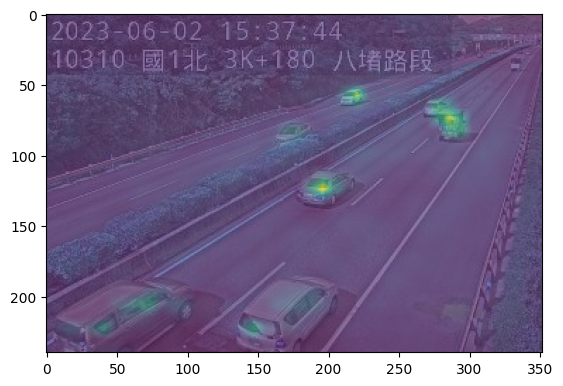

In [43]:
plt.imshow(image,alpha=0.8)
plt.imshow(predict, alpha=0.6)

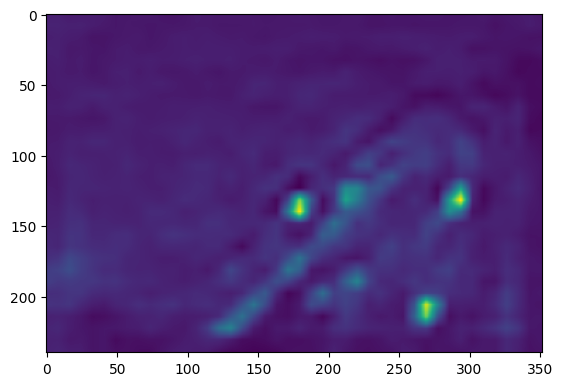

In [22]:
plt.imshow(predict)

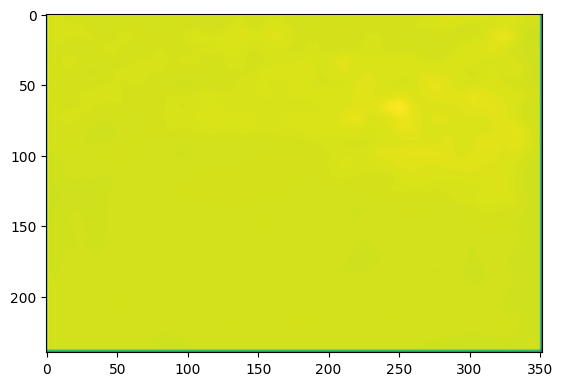

In [166]:
plt.imshow(predict/ density_map_scale)

In [133]:
demo = np.load('image/10010/2.npy')
image = cv2.imread('image/10010/2.jpg')


In [137]:
confident = np.load('image/10010/confident_2.npy')

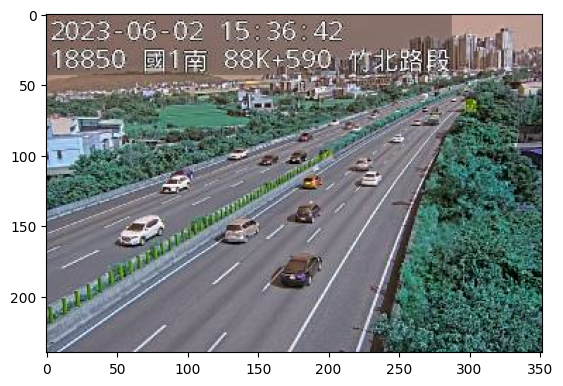

In [135]:
plt.imshow(image)

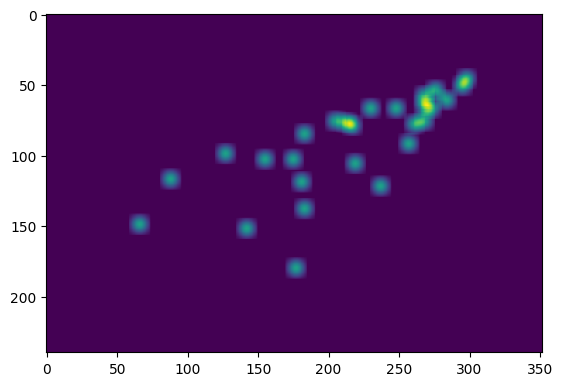

In [134]:
plt.imshow(demo)

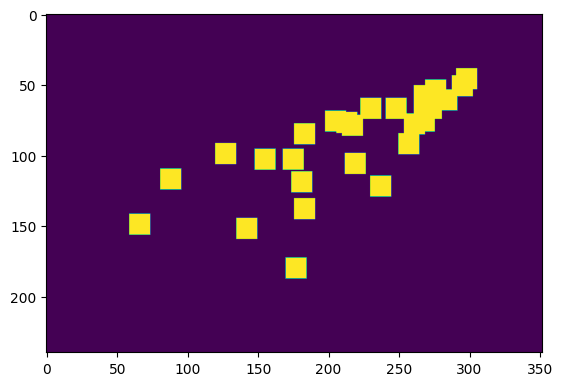

In [138]:
plt.imshow(confident)

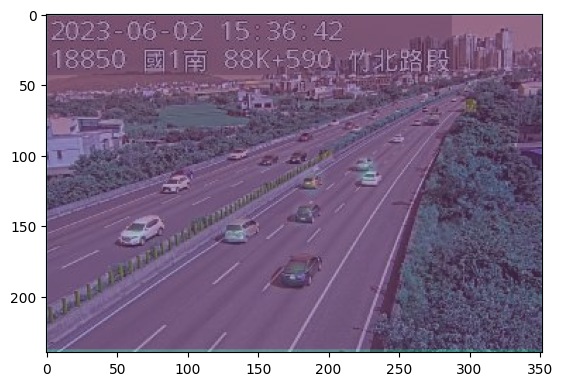

In [129]:
plt.imshow(image,alpha=0.8)
plt.imshow(demo, alpha=0.4)

In [98]:
demo = density_list[40][0].numpy().transpose((1, 2, 0))
demo.shape   

(240, 352, 1)

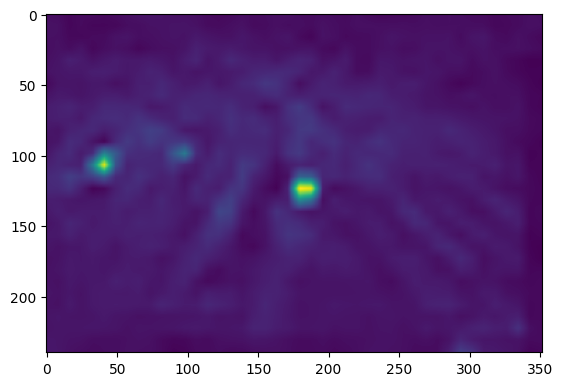

In [99]:
plt.imshow(demo)

In [26]:
demo = np.load('image/10010/2.npy')

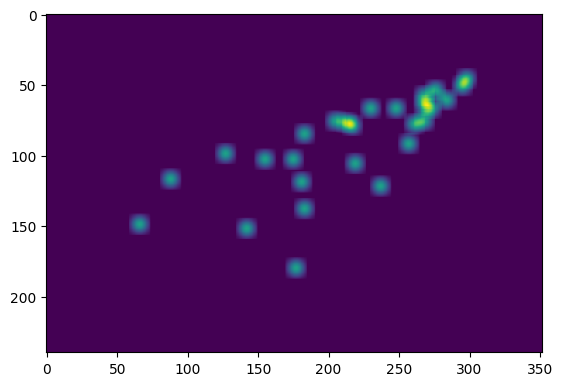

In [27]:
plt.imshow(demo)

In [92]:
'''for i in range(demo.shape[0]):
    for j in range(demo.shape[1]):
        if demo[i,j, :] > 0.8:
            demo[i,j, :] = 1
        else:
            demo[i,j, :] = 0'''

Without few shot learning

In [23]:
model = torch.load('save_weights/CSRNet_3output_weight_sigma4_relu.pt')
mae = 0.0
without_pred_density_list = []
without_prediction_list = []
for i in tqdm(range(len(images))):
    learner = model
    image_data = images[i]
    labels = density_map[i]
    # Compute validation loss
    with torch.no_grad():
        for j in range(1, len(image_data)):
            test_data = cv2.imread(image_data[j])
            test_data = transform(test_data)
            test_data = torch.unsqueeze(test_data, 0)
            test_data = test_data.to(device)
            pred_confident, pred_density, pred_final = learner(test_data)
            without_pred_density_list.append(pred_density.cpu()) 
            without_prediction_list.append(pred_final.cpu()) 
            predict_count = torch.sum(pred_final).cpu().detach().numpy().item() / density_map_scale
            label = np.load(labels[j])
            count = np.sum(label)
            error = np.abs(count - predict_count)
            mae += error
        

  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


In [24]:
mae / (4*40)

9.226651825904845

In [25]:
i = 103
predict = without_prediction_list[i][0].numpy().transpose((1, 2, 0))
predict_sum = np.sum(predict) / density_map_scale
predict = without_pred_density_list[i][0].numpy().transpose((1, 2, 0))
image = cv2.imread(test_images[i])
density = np.load(test_density[i])
predict_sum, np.sum(density)

(8.770608520507812, 11.999999999999998)

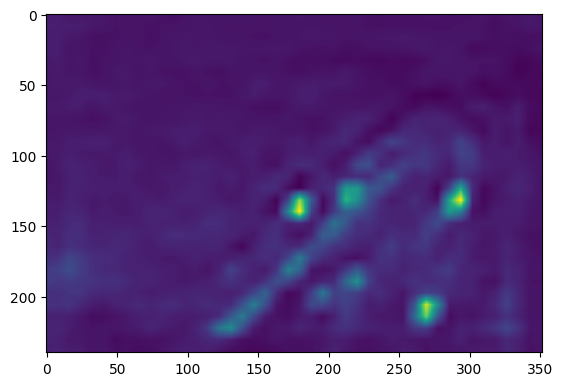

In [26]:
plt.imshow(predict)

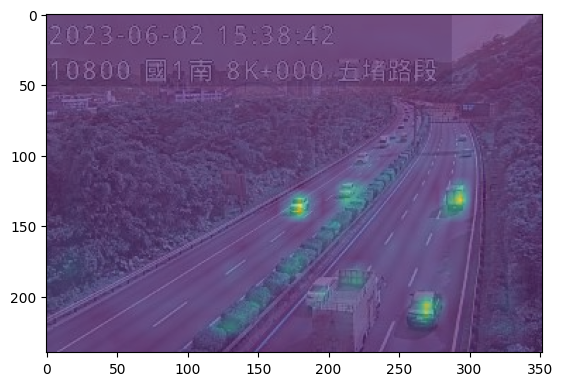

In [27]:
plt.imshow(image,alpha=0.8)
plt.imshow(predict, alpha=0.6)